<a href="https://colab.research.google.com/github/youssouf2230/Classifaction-des-fruits-avec-transfert-learning-and-fine-tuning/blob/main/Classifaction_des_fruits_avec_transfert_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tasks** Lists

### Task **1**: importer les biblithèques neccessaires

In [1]:
# importation des données
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diabatyoussouf","key":"774e75bd4891936036d47643946381d3"}'}

In [2]:
import os
import zipfile

# Créer un dossier kaggle et déplacer le fichier
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json

# Donner les permissions appropriées
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 99% 4.48G/4.54G [00:45<00:01, 38.6MB/s]
100% 4.54G/4.54G [00:45<00:00, 107MB/s] 


In [7]:
import zipfile
import os

zip_path = "fruits.zip"
extract_to = "/content/fruits_original"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

### **Task 2** : Data generators for training, valadtion and test with augmentation

In [35]:
import os
import shutil
from collections import defaultdict

def simplify_class_names(root_dir):
    """
    Regroupe les classes similaires (ex: Apple Golden 1 → apple)
    dans un nouveau répertoire organisé par fruit.
    """
    new_root = root_dir + "_merged"
    os.makedirs(new_root, exist_ok=True)
    mapping = defaultdict(list)

    for folder in os.listdir(root_dir):
        old_path = os.path.join(root_dir, folder)
        if not os.path.isdir(old_path):
            continue

        # Extraire le nom du fruit de base (le premier mot)
        base_name = folder.split()[0].lower()

        new_path = os.path.join(new_root, base_name)
        os.makedirs(new_path, exist_ok=True)

        for file in os.listdir(old_path):
            src = os.path.join(old_path, file)
            dst = os.path.join(new_path, file)
            shutil.copy(src, dst)

        mapping[base_name].append(folder)

    print(f" Classes regroupées dans {new_root}")
    return mapping


In [36]:
simplify_class_names('/content/fruits_original/fruits-360_original-size/fruits-360-original-size/Training')
simplify_class_names('/content/fruits_original/fruits-360_original-size/fruits-360-original-size/Validation')
simplify_class_names('/content/fruits_original/fruits-360_original-size/fruits-360-original-size/Test')


 Classes regroupées dans /content/fruits_original/fruits-360_original-size/fruits-360-original-size/Training_merged
 Classes regroupées dans /content/fruits_original/fruits-360_original-size/fruits-360-original-size/Validation_merged
 Classes regroupées dans /content/fruits_original/fruits-360_original-size/fruits-360-original-size/Test_merged


defaultdict(list,
            {'apple': ['Apple 10',
              'Apple 12',
              'Apple Core 1',
              'Apple 9',
              'Apple 14',
              'Apple 13',
              'Apple 5',
              'Apple 18',
              'Apple 11',
              'Apple 17',
              'Apple 7',
              'Apple 8',
              'Apple 19',
              'Apple Red Yellow 2',
              'Apple worm 1'],
             'cucumber': ['Cucumber 10',
              'Cucumber 3',
              'Cucumber 5',
              'Cucumber 1',
              'Cucumber 4',
              'Cucumber 7',
              'Cucumber 11',
              'Cucumber 9',
              'Cucumber 8'],
             'nut': ['Nut 3', 'Nut 5', 'Nut 4', 'Nut 1', 'Nut 2'],
             'onion': ['Onion 2', 'Onion White Peeled 1', 'Onion Red 2'],
             'apple_rotten_1': ['apple_rotten_1'],
             'apple_red_2': ['apple_red_2'],
             'tomato': ['Tomato 7',
              'Tomato Maroon

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data dir
train_dir = '/content/fruits_original/fruits-360_original-size/fruits-360-original-size/Training_merged'
val_dir = '/content/fruits_original/fruits-360_original-size/fruits-360-original-size/Validation_merged'
test_dir = '/content/fruits_original/fruits-360_original-size/fruits-360-original-size/Test_merged'

# data gen
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 13754 images belonging to 40 classes.
Found 6881 images belonging to 40 classes.
Found 6853 images belonging to 40 classes.


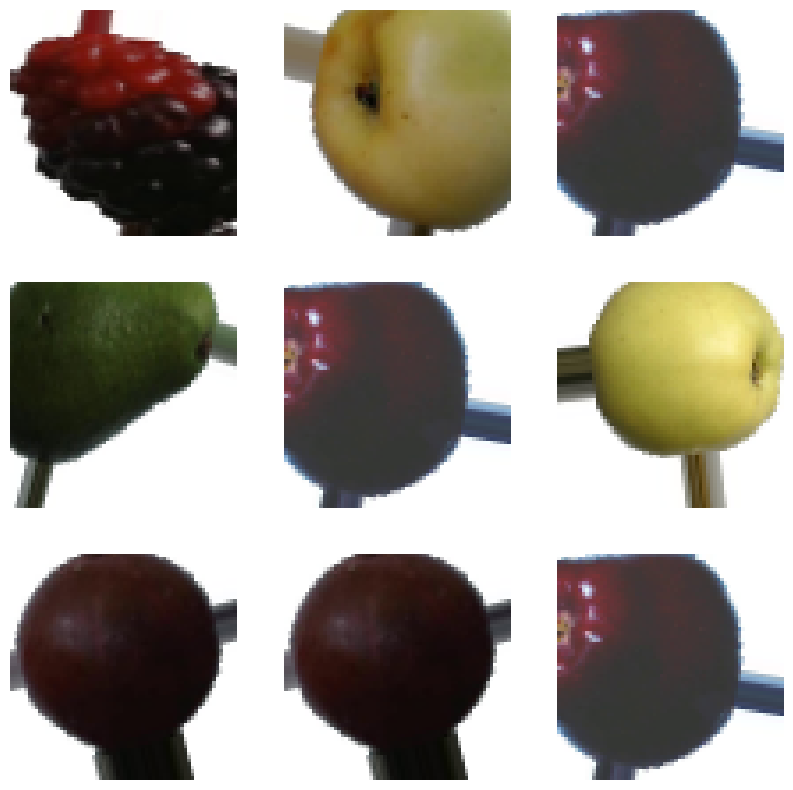

In [38]:
import matplotlib.pyplot as plt
import numpy as np

images = [train_generator[0][0][i] for i in range(9)]
# play ten image random
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[np.random.randint(0, len(images))])
    ax.axis('off')
plt.show()


### **Task 3** : Define vgg16 model architecture with custom layer

In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,GlobalMaxPooling2D,BatchNormalization

In [40]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

/tmp/ipython-input-2692209894.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


### **Task 4** : Compile model with appropriate loss and Optimizer

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,224 (9.91 MB)

 Trainable params: 338,728 (1.29 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

### **Task 5** : Train model with early stopping and learning rate scheduling

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

set_global_policy('float32')

steps_per_epochs = 50
validation_steps = 25

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epochs,
    epochs=20,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - accuracy: 0.2934 - loss: 2.9332 - val_accuracy: 0.6550 - val_loss: 1.1227 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.6601 - loss: 1.1806 - val_accuracy: 0.7887 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.7557 - loss: 0.8461 - val_accuracy: 0.8050 - val_loss: 0.5982 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.8034 - loss: 0.6640 - val_accuracy: 0.8725 - val_loss: 0.4422 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.7913 - loss: 0.6666 - val_accuracy: 0.8687 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.8351 - loss: 0.5837 - val_accuracy: 0.8913 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.8488 - loss: 0.5038 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8661 - loss: 0.4257 - val_accuracy: 0.9112 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8661 - loss: 0.4080 - val_accuracy: 0.9000 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8731 - loss: 0.4001 - val_accuracy: 0.9100 - val_loss: 0.2887 - learning_rate: 0.0010
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8571 - loss: 0.4295
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8573 - loss: 0.4291 - val_accuracy: 0.8963 - val_loss: 0.3076 - learning_rate: 0.0010
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.8754 - loss: 0.3946 - val_accuracy: 0.9075 - val_loss: 0.2699 - learning_rate: 1.0000e-04
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9058 - loss: 0.3121 - va

### Task 6 : Fine tune the model by unfreezing specific layer in VGG16

In [44]:
num_layers = len(model.layers)
print(num_layers)

6


In [45]:
import tensorflow as tf
# freeze layer
for layer in model.layers[-5:]:
    layer.trainable = True

# freeze batchNor layer
for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
# re-compile model
model.compile(optimizer= tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [46]:
history_fine =  model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epochs,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.9071 - loss: 0.2837 - val_accuracy: 0.9375 - val_loss: 0.1893 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9140 - loss: 0.2802 - val_accuracy: 0.9413 - val_loss: 0.1866 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9185 - loss: 0.2666 - val_accuracy: 0.9388 - val_loss: 0.1949 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.9216 - loss: 0.2599 - val_accuracy: 0.9325 - val_loss: 0.1999 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9157 - loss: 0.2828
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9158 - loss: 0.2825 - val_accuracy: 0.9312 - val_loss: 0.2127 - learning_rate: 1.0000e-05


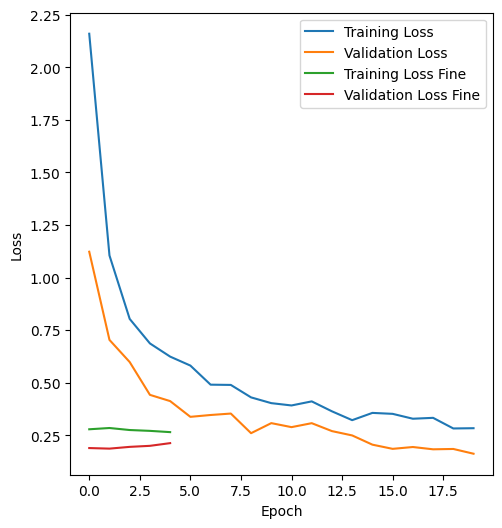

In [47]:
# compare curve history vs history fine

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Training Loss Fine')
plt.plot(history_fine.history['val_loss'], label='Validation Loss Fine')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

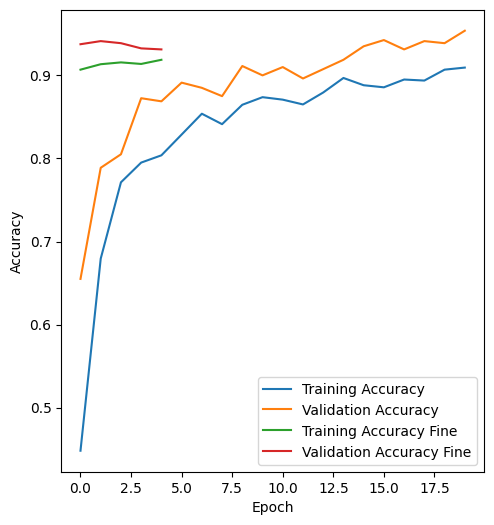

In [48]:
# compare curve history vs history fine

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Training Accuracy Fine')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy Fine')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


On constate clairement qu’avec le fine-tuning, le modèle atteint pratiquement la même performance que le modèle de référence après seulement 5 époques. De plus, les résultats de validation montrent des performances similaires entre les deux modèles.

In [49]:
# evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

215/215 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.9357 - loss: 0.1976
Test accuracy: 0.9416313767433167


In [50]:
# do predictions
predictions = model.predict(test_generator)

215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step


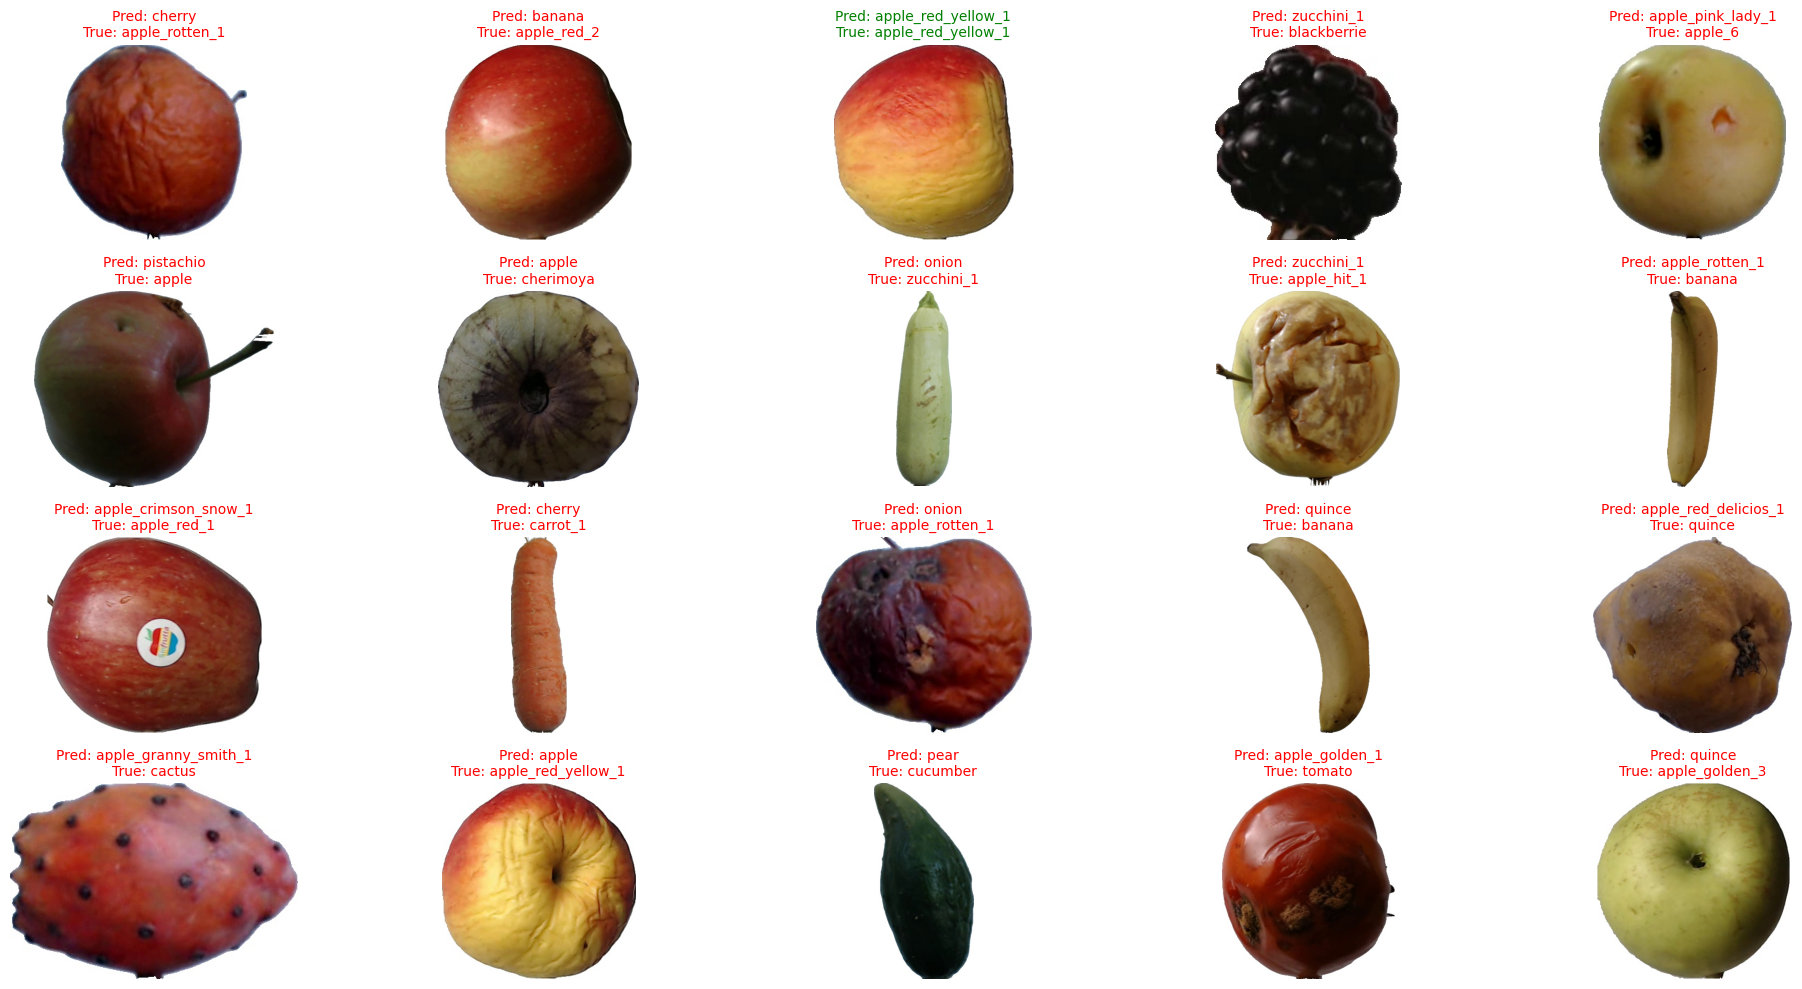

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import random

# récupérer les classes prédictes et réelles
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# on génère 20 indices aléatoires parmi toutes les images du test set
random_indices = random.sample(range(len(true_classes)), 20)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(random_indices):
    # récupérer l'image correspondante dans test_generator
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)

    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[predicted_classes[idx]]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
